# Compute the Icing Days Climate Index

This notebook computes the **Icing Days index**: starting from the daily maximum temperature (1980-1990) TX,
the Frost Days index is the number of days where $TX < 0°$

As first step, let's connect to the remote ECAS instance

In [1]:
from PyOphidia import cube
cube.Cube.setclient(read_env=True)

Current cdd is /home/ecasuser
Current session is https://ophidialab.cmcc.it/ophidia/sessions/28428206836738622831574257875438385/experiment
Current cwd is /
The last produced cube is https://ophidialab.cmcc.it/ophidia/6253/850326


Import input NetCDF data set (with maximum temperature in °K)

In [2]:
maxtemp = cube.Cube(src_path='/public/data/ecas_training/E63_kp40_198001_199012_T2m_daymax_merged.nc',
    measure='temp2',
    import_metadata='yes',
    imp_dim='time',
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=4,
    description='Max Temps'
    )

New cube is https://ophidialab.cmcc.it/ophidia/6255/850334


Identify the icing days: $\{day \mid TX(day) < 273.15\}$  with apply (we are basically creating a mask)

In [3]:
icingdays = maxtemp.apply(
    query="oph_predicate('OPH_FLOAT','OPH_INT',measure,'x-273.15','<0','1','0')"
)

Count the number of yearly icing days

In [4]:
count = icingdays.reduce2(
    operation='sum',
    dim='time',
    concept_level='y',
)

Subset on the first year

In [5]:
firstyear = count.subset(subset_filter=1, subset_dims='time')

Plot the indicator on a map

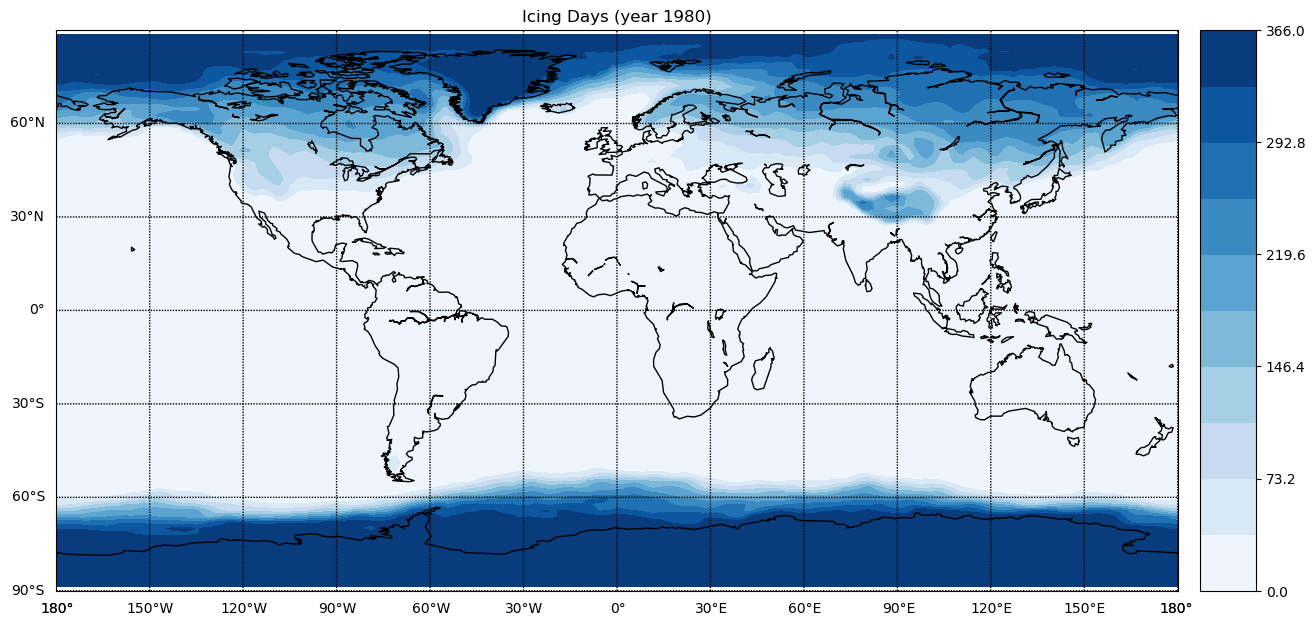

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm, addcyclic, shiftgrid
import numpy as np

data = firstyear.export_array(show_time='yes')
lat = data['dimension'][0]['values'][:]
lon = data['dimension'][1]['values'][:]
var = data['measure'][0]['values'][:]
var = np.reshape(var, (len(lat), len(lon)))

fig = plt.figure(figsize=(15, 15), dpi=100)
ax  = fig.add_axes([0.1,0.1,0.8,0.8])

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180, lon_0=0, resolution='c')

map.drawcoastlines()
map.drawparallels(np.arange( -90, 90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

var_cyclic, lon_cyclic = addcyclic(var, lon)
var_cyclic, lon_cyclic  = shiftgrid(180., var_cyclic, lon_cyclic, start=False)
x, y = map(*np.meshgrid(lon_cyclic,lat))

levStep = (np.max(var)-np.min(var))/10
clevs = np.arange(np.min(var),np.max(var)+levStep,levStep)

cnplot = map.contourf(x,y,var_cyclic,clevs,cmap=plt.cm.Blues)
cbar = map.colorbar(cnplot,location='right')

plt.title('Icing Days (year 1980)')
plt.show()

To clear your workspace before running other notebooks

In [7]:
cube.Cube.deletecontainer(container='E63_kp40_198001_199012_T2m_daymax_merged.nc',force='yes')